# Identify a "Formula"

Hip-hop music has been notorious for its lack of musical accomplishment and the brutality of lyrics in its harshness and repetition, in particular, the glorification of criminal activities, the promotion of drug use, and misogyny that justifies the objectification and exploitation of women. Hip-hop’s egotistical worldview reminds anyone living in urban America of the scene that young gangsters strolling down streets, blaring the sonic weapon from their boom boxes or souped-up cars, with defiant glares and gestures daring anyone to ask them to turn it down. It outrageous belligerence and profanity pushes me to wonder: how in the world can music be this harmful? 

From the perspective of data science, I will use [Billboard Hot 100](https://en.wikipedia.org/wiki/Billboard_Hot_100) ranking data from 1950 to 2015, joined with a separate dataset of artists’ genres and [API](https://www.last.fm/api/show/track.getInfo) data of play counts and listener counts. The following analysis is to identify the following music formula: hip-hop carriers messages with a greater amount of negativity compared to other music genres, and it’s getting more and more antisocial throughout the years.

## Data modeling

In [1]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pyLDAvis.gensim
import statsmodels.formula.api as smf
import requests
from bs4 import BeautifulSoup
import re
import spacy
import nltk
import gensim

/Users/yanwenwang/anaconda3/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/Users/yanwenwang/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning:

`formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly

/Users/yanwenwang/anaconda3/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/Users/yanwenwang/anaconda3/lib/python3.7/site-packages/nltk/lm/vocabulary.py:13: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/Users/yanwenwang/anaconda3/lib/python3.7/site-packages/scip

In [2]:
# Text processing by spaCy
def add_spacy_data(dataset, feature_column):
    
    verbs = []
    nouns = []
    adverbs = []
    corpus = []
    
    nlp = spacy.load('en_core_web_sm')
    
    for i in range (0, len(dataset)):
        print("Extracting from record {} of {}".format(i+1, len(dataset)), end = "\r")
        song = dataset.iloc[i][feature_column]
        doc = nlp(song)
        spacy_dataframe = pd.DataFrame()
        
        for token in doc:
            if token.lemma_ == "-PRON-":
                    lemma = token.text
            else:
                lemma = token.lemma_
            row = {
                "Word": token.text,
                "Lemma": lemma,
                "PoS": token.pos_,
                "Stop Word": token.is_stop
            }
            spacy_dataframe = spacy_dataframe.append(row, ignore_index=True)
            
        verbs.append(" ".join(spacy_dataframe["Lemma"][spacy_dataframe["PoS"] == "VERB"].values))
        nouns.append(" ".join(spacy_dataframe["Lemma"][spacy_dataframe["PoS"] == "NOUN"].values))
        adverbs.append(" ".join(spacy_dataframe["Lemma"][spacy_dataframe["PoS"] == "ADV"].values))
        corpus_clean = " ".join(spacy_dataframe["Lemma"][spacy_dataframe["Stop Word"] == False].values)
        corpus_clean = re.sub(r'[^A-Za-z0-9]+', ' ', corpus_clean)   
        corpus.append(corpus_clean)
        
    dataset['Verbs'] = verbs
    dataset['Nouns'] = nouns
    dataset['Adverbs'] = adverbs
    dataset['Corpus'] = corpus
    
    return dataset


# Get play counts and listener counts from last.fm
API_KEY = 'ace7d5a577782eaef5d954a0e4fb8be1'
def get_play_listener_counts(dataset):
    dataset['play_counts'] = float("NaN")
    dataset['listener_counts'] = float("NaN")
    for i in range(0, len(dataset)):
        print("Scraping record {} of {}".format(i+1, len(dataset)), end = "\r")
        artist = music_df.loc[i]['artist']
        title = music_df.loc[i]['title']
        url = 'http://ws.audioscrobbler.com/2.0/?method=track.getInfo&api_key={API_KEY}&artist={artist}&track={title}'.format(API_KEY = API_KEY, 
                                                                                                                          artist = artist,
                                                                                                                          title = title)
        html = requests.get(url)
        soup = BeautifulSoup(html.text, 'html.parser')
        try:
            play_count = pd.to_numeric(soup.find('playcount').text)
            listener_count = pd.to_numeric(soup.find('listeners').text)
        except:
            pass
        
        dataset['play_counts'][i] = play_count
        dataset['listener_counts'][i] = listener_count
    
    return dataset

In [3]:
# Import datasets
music_df = pd.read_csv('music_df.csv')
artist_genre = pd.read_csv('features_dataset.csv')

# Merge two datasets to identify song genres
music_df = pd.merge(music_df, artist_genre[['artist', 'main_genre']], 
                    on='artist', how = 'left').drop_duplicates(['lyrics', 'artist', 'uri']).reset_index(drop=True)

# Format year bins
music_df['year_bin'] = music_df['year_bin'].apply(lambda x: '20'+x if (x == '10s') or (x == '00s') else '19'+x)

In [4]:
# Extract Verbs, Nouns, and the Corpus
music_df = add_spacy_data(music_df, 'lyrics')

In [5]:
# Count total words and unique words
word_counts = []
unique_word_counts = []

for i in range (0, len(music_df)):
    word_counts.append(len(music_df.iloc[i]['lyrics'].split()))
    unique_word_counts.append(len(set(music_df.iloc[i]['lyrics'].split())))
    
music_df['word_counts'] = word_counts
music_df['unique_word_counts'] = unique_word_counts

In [6]:
# Get play counts and listener counts
music_df = get_play_listener_counts(music_df)

In [7]:
# Identify bad words
bad_word_file = 'facebook-bad-words-list_comma-separated-text-file_2018_07_29.txt'
with open(bad_word_file) as f:
    bad_words_list = f.read().split(", ")

bad_words_per_song = []
for i in range (0, len(music_df)):
    bad_words_found = []
    for bad_word in bad_words_list:
        if bad_word in music_df.iloc[i]['Corpus']:
            print("Found bad word in record: {}".format(i), end="\r")
            bad_words_found.append(bad_word)
    bad_words_per_song.append(bad_words_found)

music_df['bad_words'] = bad_words_per_song

num_bad_words = []
for i in range (0, len(music_df)):
    num_bad_words.append(len(music_df.iloc[i]['bad_words']))
    
music_df['num_bad_words'] = num_bad_words
music_df['freq_bad_words'] = music_df['num_bad_words']/music_df['word_counts']

In [31]:
# Re-classfiy the music genres
music_df['two_genres'] = music_df['main_genre']
music_df['two_genres'][music_df['main_genre']!='hip-hop'] = 'Other'

# Categorize sentiment scores
music_df['positivity'] = music_df['compound']
music_df['positivity'][music_df['compound']>=0] = 1
music_df['positivity'][music_df['compound']<0] = 0

In [32]:
music_df.to_csv('music_df_final.csv')

In [33]:
# Load this csv to avoid running the above codes
music_df = pd.read_csv('music_df_final.csv')

music_df.head()

,Unnamed: 0,Unnamed: 0.1,lyrics,num_syllables,pos,year,fog_index,flesch_index,num_words,num_lines,...,Corpus,word_counts,unique_word_counts,play_counts,listener_counts,bad_words,num_bad_words,freq_bad_words,two_genres,positivity
0,0,0,"Mona Lisa, Mona Lisa, men have named you\nYou'...",189.0,0.199,1950,5.2,88.74,145,17,...,Mona Lisa Mona Lisa man name like lady mystic ...,145,63,409302.0,147157.0,[],0,0.000000,Other,1.0
1,1,1,I wanna be Loved\nBy Andrews Sisters\n\nOooo-o...,270.9,0.224,1950,4.4,82.31,189,31,...,wanna love Andrews Sisters Oooo ooooh Oooo ooo...,189,81,13304.0,6250.0,"['ass', 'ho', 'tart']",3,0.015873,Other,1.0
2,2,2,I was dancing with my darling to the Tennessee...,174.6,0.351,1950,5.2,88.74,138,16,...,dance darling Tennessee Waltz old friend happe...,138,44,105101.0,39400.0,[],0,0.000000,Other,1.0
3,3,3,Each time I hold someone new\nMy arms grow col...,135.9,0.231,1950,4.4,99.23,117,18,...,time hold new arm grow cold aching place darle...,117,76,3904.0,1732.0,"['ho', 'slave']",2,0.017094,Other,1.0
4,4,4,"Unfortunately, we are not licensed to display ...",46.8,0.079,1950,6.0,69.79,32,3,...,unfortunately license display lyric song momen...,32,28,7739.0,3728.0,['ho'],1,0.031250,Other,1.0


## Sentiment analysis of genres

### Overall sentiment scores

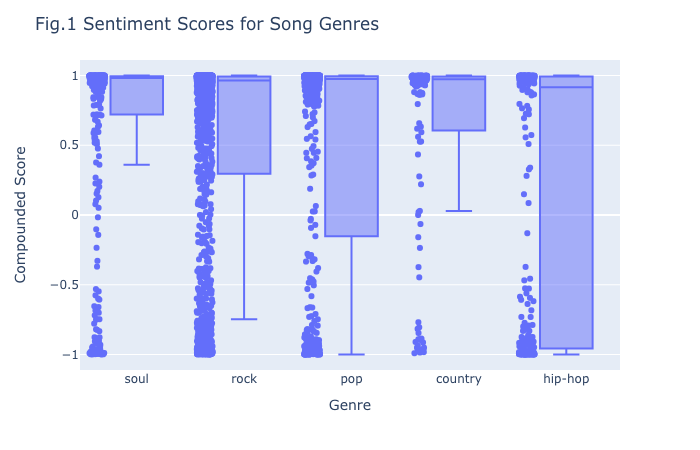

In [11]:
popular_genres = music_df['main_genre'].value_counts().index[:5] # Keep only the 5 most popular genres

fig = px.box(music_df[music_df['main_genre'].isin(popular_genres)], x='main_genre', y='compound', points='all')

fig.update_layout(title = 'Fig.1 Sentiment Scores for Song Genres',
                  xaxis = dict(title = 'Genre'),
                  yaxis = dict(title = 'Compounded Score'))

fig.show('png')

### Sentiment scores overtime

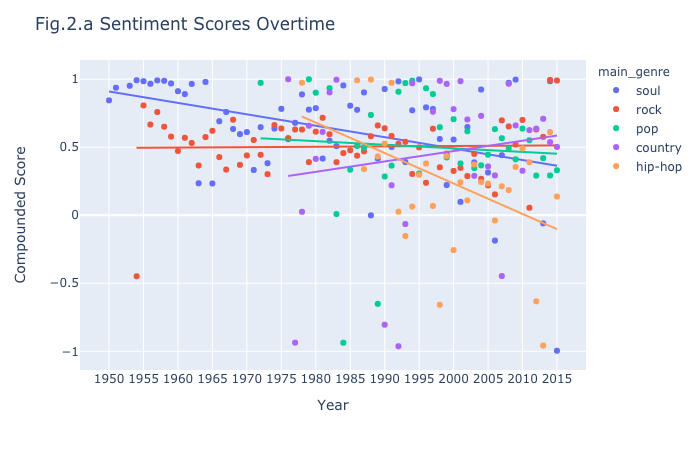

In [12]:
fig = px.scatter(music_df[music_df['main_genre'].isin(popular_genres)].groupby(['year', 'main_genre'])['compound'].mean().reset_index(),
              x = 'year', y = 'compound', color = 'main_genre', trendline='ols')
fig.update_xaxes(tick0=1950, dtick=5)

fig.update_layout(title = 'Fig.2.a Sentiment Scores Overtime',
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Compounded Score'))

fig.show('png')

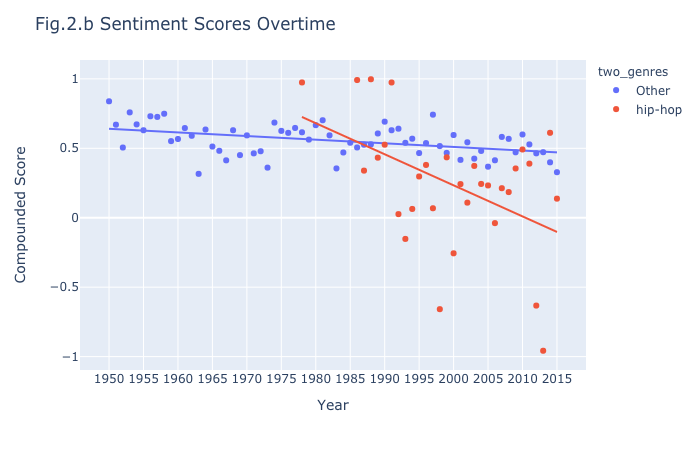

In [13]:
fig = px.scatter(music_df.groupby(['year', 'two_genres'])['compound'].mean().reset_index(),
              x = 'year', y = 'compound', color = 'two_genres', trendline='ols')
fig.update_xaxes(tick0=1950, dtick=5)

fig.update_layout(title = 'Fig.2.b Sentiment Scores Overtime',
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Compounded Score'))

fig.show('png')

Figure 1, 2.a, and 2.b visualized the sentiment scores of song lyrics, in which the first graph summarized the sentiment score of genres from 1950 to 2015, and the latter two showed the trend of sentiment changes over the years. The three graphs clearly demonstrated the formula that lyrics of hip-hop music carry an overall greater amount of negativity compared to other genres. Surprisingly, when hip-hop first entered the mainstream music industry in 1978, it was actually the most positive genre among the five most popular genres: rock, country, soul, pop and hip-hop. However, its sentiment score declined at a faster rate than any other genres. Since 2000s, hip-hop has been *de facto* the most negative music genre.

# Interpret the "Formula"

## Legisign relationships

The term “hip-hop” describes a culture developed by inner-city African American youth and Latino American youth in the 1970s, with the rap music as the essential cultural element. Characterized by its continuous beats and rhythm, along with its unapologetic protest of social injustice through lyrics, hip-hop soon became a new form of musical expression and spiritual vessel “for open social reflection on poverty, fear of adulthood, the desire for absent fathers…, raw anger, violence and childhood memories (Rose, 1994, p. 18).”

Nevertheless, hip-hop was criticized for its associated violence and negativity. Hip-hop artists take pride in sexual abuse and calling their women “bitches”, “whores” and “gold diggers”: */ before you hit on a bitch you have to find a contraceptive/ If you got a gang of niggers the bitch’ll let you rape her/ And all bitches are created equal…* (Dr. Dre, 1992; N.W.A., 1990). They take pride in drug abuse and the call for violence: */ taking out a police will make my day/ if your bitches talk shit, I have to put the smack down/ Sucka-ass nigga, I should shoot you dead* (N.W.A., 1989; Dr. Dre, 1992; Schoolly D, 1985). Such content of hip-hop music indicates an ill approach to empowerment by attacking racism with more racism and fighting against lack of power through supremacy. Studies have demonstrated hip-hop’s detrimental effects on the health and social outcomes of adolescents (Wingood et al.,  2003). Compared with adolescents who has less exposure to rap music videos, adolescents who had great exposure were “3 times more likely to have hit a teacher; more than 2.5 times as likely to have been arrested; 2 times as likely to have had multiple sexual partners; and more than 1.5 times as likely to have acquired a new sexually transmitted disease, used drugs, and used alcohol over the 12-month follow-up period (Wingood et al.,  2003).”

Hip-hop’s lyrics, as a cultural product, is likely to mirror the psychological background and individualistic traits of its audience (Dewall, Pond, Campbell, & Twenge,  2011). Here I will continue to perform the text analysis and make hypotheses that the following three legisigns are associated with its negativity:
- **Popularity (number of plays and listeners)**: As the overall musical taste has become increasingly self-focus and anti-social, popularity of hip-hop music is expected to increase (Dewall, Pond, Campbell, & Twenge,  2011). In addition, within the hip-hop music genre, the nastier a song is, the more popular it will become.
- **Profanity (number and frequency of bad words)**: Hip-hop songs have significantly greater frequency of bad words, compared to other genres.
- **Word counts**: Hip-hop music is expected to have significantly more words than other music. The more words a song has, more likely it will convey negative messages. 

Other than testing the three legisigns, I will also perform topic modeling of hip-hop lyrics and build two regression models: the former predicting sentiment score and the latter predicting popularity.

## Test the legisign relationships

### Popularity

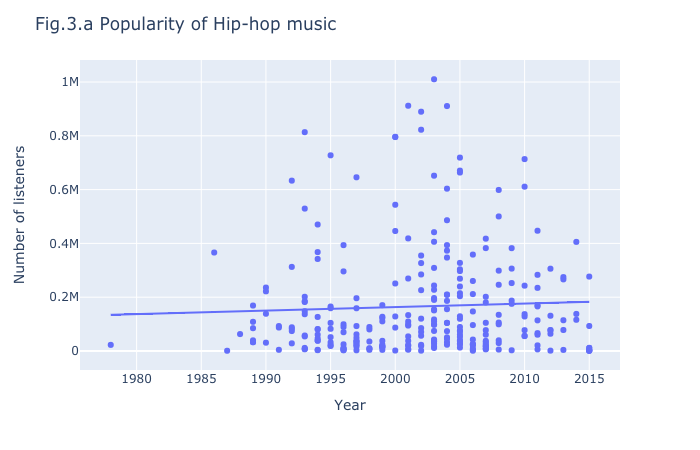

In [14]:
fig = px.scatter(music_df[music_df['main_genre']=='hip-hop'],
                 x='year', y='listener_counts', trendline='ols')
fig.update_xaxes(tick0=1975, dtick=5)

fig.update_layout(title = 'Fig.3.a Popularity of Hip-hop music',
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Number of listeners'))

fig.show('png')

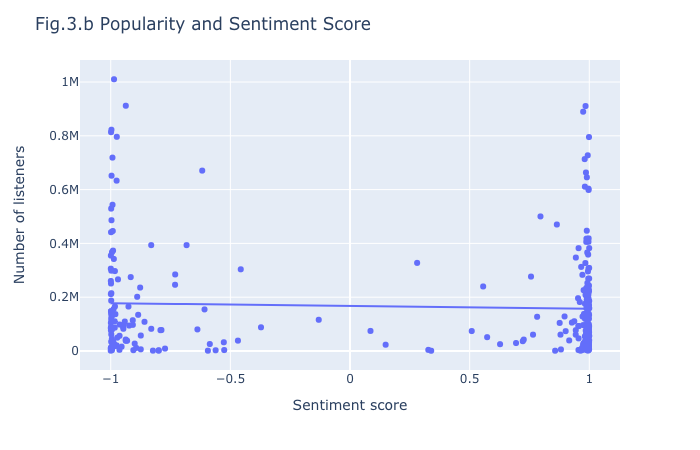

In [15]:
fig = px.scatter(music_df[music_df['main_genre']=='hip-hop'],
                 x='compound', y='listener_counts', trendline='ols')

fig.update_layout(title = 'Fig.3.b Popularity and Sentiment Score',
                  xaxis = dict(title = 'Sentiment score'),
                  yaxis = dict(title = 'Number of listeners'))

fig.show('png')

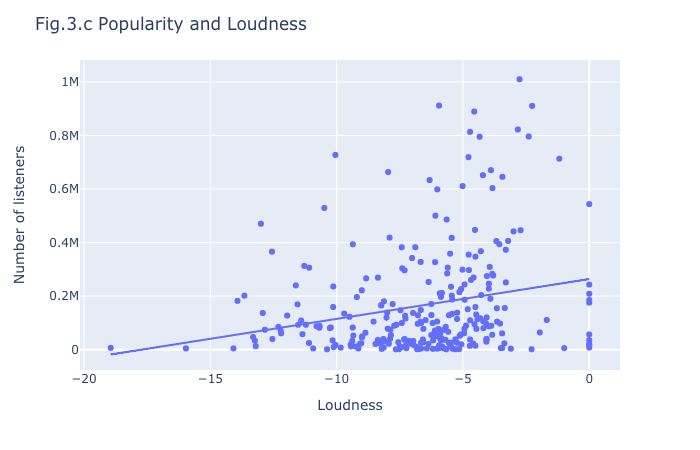

In [16]:
fig = px.scatter(music_df[music_df['main_genre']=='hip-hop'],
                 x='loudness', y='listener_counts', trendline='ols')

fig.update_layout(title = 'Fig.3.c Popularity and Loudness',
                  xaxis = dict(title = 'Loudness'),
                  yaxis = dict(title = 'Number of listeners'))

fig.show('png')

### Profanity

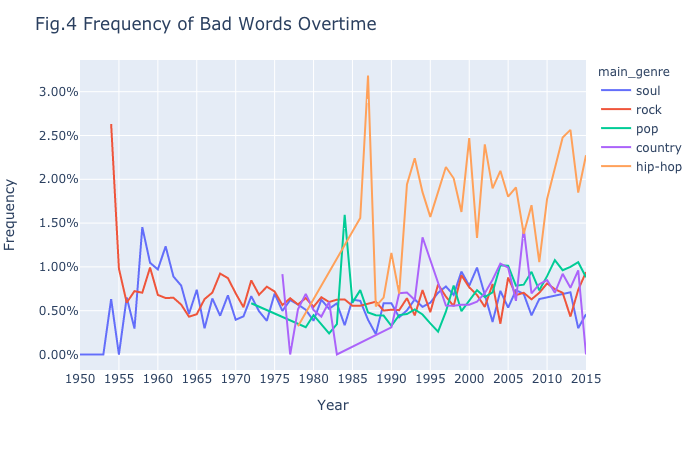

In [24]:
bad_words_df = music_df[music_df['main_genre'].isin(popular_genres)].groupby(['year', 'main_genre'])['word_counts', 'num_bad_words'].sum().reset_index()
bad_words_df['freq_bad_words'] = bad_words_df['num_bad_words']/bad_words_df['word_counts']

fig = px.line(bad_words_df, x = 'year', y = 'freq_bad_words', color = 'main_genre')
fig.update_xaxes(tick0=1950, dtick=5)

fig.update_layout(title = 'Fig.4 Frequency of Bad Words Overtime',
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Frequency', tickformat=".2%"))

fig.show('png')

### Word Counts

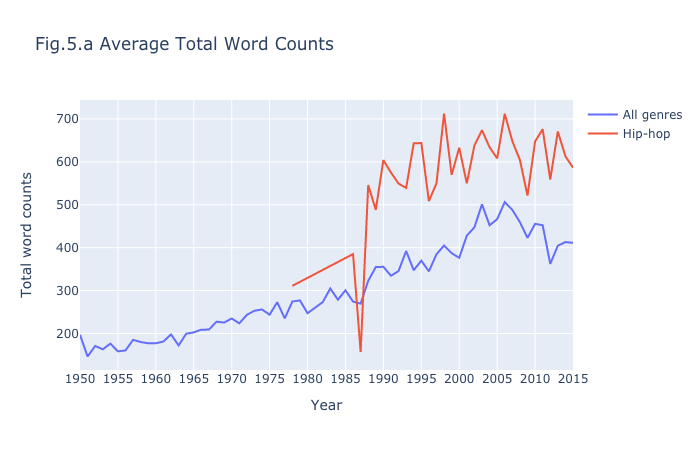

In [25]:
word_counts_df = music_df.groupby('year')['word_counts', 'unique_word_counts'].mean().reset_index()
word_counts_rap_df = music_df[music_df['main_genre']=='hip-hop'].groupby('year')['word_counts', 'unique_word_counts'].mean().reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x = word_counts_df['year'], y = word_counts_df['word_counts'],
                         mode='lines',
                         name='All genres'))
fig.add_trace(go.Scatter(x = word_counts_rap_df['year'], y = word_counts_rap_df['word_counts'],
                         mode='lines',
                         name='Hip-hop'))
fig.update_xaxes(tick0=1950, dtick=5)

fig.update_layout(title = 'Fig.5.a Average Total Word Counts',
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Total word counts'))

fig.show('png')

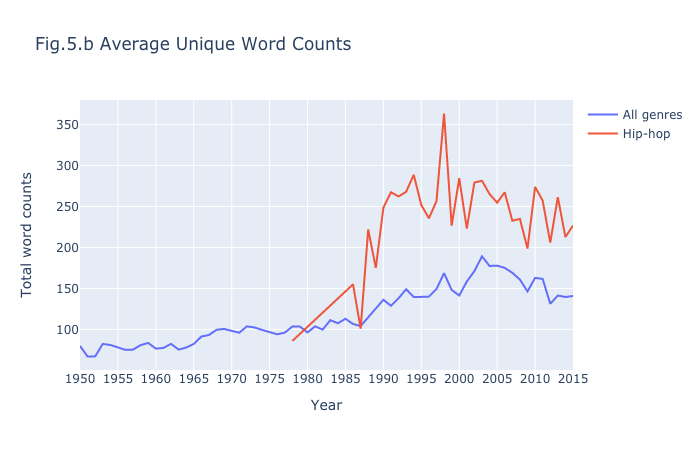

In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = word_counts_df['year'], y = word_counts_df['unique_word_counts'],
                         mode='lines',
                         name='All genres'))
fig.add_trace(go.Scatter(x = word_counts_rap_df['year'], y = word_counts_rap_df['unique_word_counts'],
                         mode='lines',
                         name='Hip-hop'))
fig.update_xaxes(tick0=1950, dtick=5)

fig.update_layout(title = 'Fig.5.b Average Unique Word Counts',
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Total word counts'))

fig.show('png')

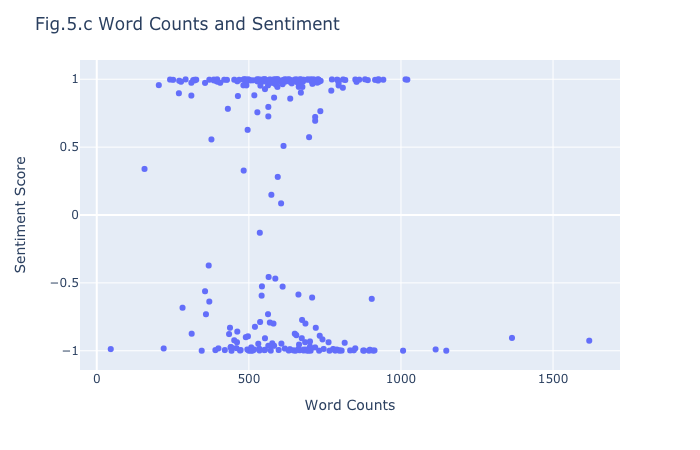

In [29]:
fig = px.scatter(music_df[music_df['main_genre']=='hip-hop'],
                 x='word_counts', y='compound')
                 
fig.update_layout(title = 'Fig.5.c Word Counts and Sentiment',
                  xaxis = dict(title = 'Word Counts'),
                  yaxis = dict(title = 'Sentiment Score'))

fig.show('png')

### Topic modeling

In [20]:
words = gensim.corpora.Dictionary(music_df[music_df['main_genre']=='hip-hop']['Nouns'].str.split())

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in music_df[music_df['main_genre']=='hip-hop']['Nouns'].str.split()]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=words,
                                            num_topics=5, 
                                            random_state=2,
                                            update_every=1,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

topics = lda_model.print_topics(num_topics = 5)

for topic in topics:
    print(topic)

(0, '0.057*"love" + 0.029*"way" + 0.022*"life" + 0.022*"girl" + 0.021*"baby" + 0.017*"time" + 0.014*"chick" + 0.014*"one" + 0.012*"heart" + 0.012*"world"')
(1, '0.033*"man" + 0.017*"wit" + 0.015*"head" + 0.011*"spot" + 0.011*"jump" + 0.009*"club" + 0.009*"girl" + 0.009*"back" + 0.008*"thing" + 0.007*"people"')
(2, '0.027*"girl" + 0.021*"bitch" + 0.015*"way" + 0.013*"night" + 0.012*"shit" + 0.012*"ass" + 0.012*"baby" + 0.010*"time" + 0.010*"thing" + 0.009*"day"')
(3, '0.047*"baby" + 0.018*"time" + 0.018*"girl" + 0.017*"body" + 0.012*"music" + 0.012*"love" + 0.010*"way" + 0.010*"night" + 0.010*"dirty" + 0.009*"day"')
(4, '0.030*"ass" + 0.019*"shit" + 0.017*"girl" + 0.015*"bitch" + 0.013*"bit" + 0.012*"nigga" + 0.010*"way" + 0.010*"baby" + 0.007*"thing" + 0.007*"man"')


In [21]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, words)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.024414 -0.040945       1        1  34.489201
3      0.057341  0.029176       2        1  18.350004
4     -0.097648 -0.066013       3        1  17.067837
0      0.104128 -0.042174       4        1  15.925860
1     -0.039407  0.119957       5        1  14.167094, topic_info=      Term        Freq       Total Category  logprob  loglift
40    love  378.000000  378.000000  Default  30.0000  30.0000
109   baby  488.000000  488.000000  Default  29.0000  29.0000
8      man  269.000000  269.000000  Default  28.0000  28.0000
521    ass  281.000000  281.000000  Default  27.0000  27.0000
94    life  189.000000  189.000000  Default  26.0000  26.0000
..     ...         ...         ...      ...      ...      ...
109   baby   23.656513  488.957306   Topic5  -5.0542  -1.0744
201  woman   15.366014   68.195534   Topic5  -5.4857   0.4640
56     way   16.919538  375.142365   Topic5  -5.3894  -1.1446
18     boy   15.676569  141.433975   Topic5  -5.4657  -0.2454
521    ass   15.030777  281.113770   Topic5  -5.5078  -0.9744

[368 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
3154      1  0.941109                 (in
2177      2  0.874841             Bouncin
16        1  0.630352                 air
16        2  0.162671                 air
16        3  0.081336                 air
...     ...       ...                 ...
107       3  0.098966               world
107       4  0.365415               world
107       5  0.197933               world
1961      1  0.896481               ya'll
1899      3  0.780327  youknowhati'msayin

[710 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 1, 2])

### Regression model

In [36]:
mod = smf.ols(formula = 'compound ~ listener_counts + word_counts + freq_bad_words + year + energy + loudness + danceability + speechiness + instrumentalness + fog_index', 
              data = music_df[music_df['main_genre']=='hip-hop'])
res= mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               compound   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     8.057
Date:                Sun, 23 Feb 2020   Prob (F-statistic):           2.37e-11
Time:                        17:55:17   Log-Likelihood:                -333.72
No. Observations:                 277   AIC:                             689.4
Df Residuals:                     266   BIC:                             729.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -5.6898     16.235  

In [23]:
mod = smf.ols(formula = 'listener_counts ~ word_counts + year + compound + freq_bad_words + energy + loudness + danceability + speechiness + instrumentalness + fog_index', 
              data = music_df[music_df['main_genre']=='hip-hop'])
res= mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        listener_counts   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     3.290
Date:                Sun, 23 Feb 2020   Prob (F-statistic):           0.000488
Time:                        12:07:27   Log-Likelihood:                -3759.2
No. Observations:                 277   AIC:                             7540.
Df Residuals:                     266   BIC:                             7580.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3.659e+06   3.81e+06  

## Explanations

The analysis didn’t find any significant correlation between popularity of hip-hop and year, nor between popularity and sentiment scores. The popularity of hip-hop music remained stable throughout the years. Among those, few songs received a neutral sentiment score while most of hip-hop songs are either extremely positive or extremely negative. Therefore, the hypothesis that nastier songs are more popular is invalid. However, I did find that popularity of hip-hop music is positively correlated with loudness.

One potential explanation is the limitation of sampling method. All songs included in the Billboard Hot 100 dataset are popular, which leaves us with no room to study what quality should a song have to be able to get popularity. 

Figure 4 successfully confirmed the hypothesis that hip-hop music has significantly greater frequency of bad words, compared to other genres. While hip-hop music first entered the billboard in 1978 with a similar frequency of bad words, its profanity quickly increased and remained the highest since the 1990s.

Figure 5 indicated that hip-hop music has significantly higher word counts compared to other genres. However, due to the fact that sentiment scores are extremely polarized, I didn’t find a significant correlation between word counts and sentiment.

After testing the three legisign relationships, I performed a topic modeling and two regression analyses. The topic modeling provided a more intuitive examination of hip-hop’s content. In topic three, the word “girl” appears frequently with profane words such as “ass”, “bitch”, “shit”, “nigga”, which indicated hip-hop’s tendency to degrade women. Such patterns are also identifiable in other topics where women are often described through words related to sex and money.

Lastly, the two regression models predicted hip-hop’s sentiment scores and popularity respectively. In the first model, the only two significant variables are word counts and frequency of bad words. In the second model, popularity of hip-hop music is largely affected by its loudness and energy level.

One of the major limitations of this study is that analyzing popularity from an already popular sample is unscientific. During this process, various factors that contributed to popularize a song were ignored.


# References

- Dewall N., Pond, R. S., Campbell, W. K., &amp; Twenge, J. M. (2011). Tuning in to Psychological change: Linguistic markers of psychological traits and emotions over time in popular U.S. song lyrics. *Psychology of Aesthetics, Creativity, and the Arts*, 5(3), 200-207.
- Dr. Dre. (1992). *Nuthin’ But a ‘G’ Thang*. (Song Recording). 
- N.W.A. (1989). *Fuck the Police*. (Song Recording).
- N.W.A. (1990). *One Less Bitch*. (Song Recording).
- Rose, T. (1994). *Black noise: Rap music and black culture in contemporary America*. Hanover, NH: Wesleyan University Press.
- Schooly D. (1985). *PSK What Does It Mean?* (Song Recording).
- Wingood M., Diclemente, R. J., Bernhardt, J. M., Harrington, K., Davies, S. L., Robillard, A., &amp; Hook, E. W. (2003). A prospective study of exposure to rap music videos and african american female adolescents’ health. *American Journal of Public Health*, 93(3), 437-439.
